In [ ]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click to toggle code"></form>''')

# Data based saturation correction for high energy events in XENON1T
* Yuehuan Wei and Fei Gao, Dec 12th, 2016




In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit       # curve fitting libraries
import pandas as pd
from matplotlib.colors import LogNorm
from collections import defaultdict
from array import array
import pylab
import ROOT

In [4]:
### hax ###
import hax
hax.__version__

hax.init(raw_data_access_mode = 'local',
         raw_data_local_path = '/Users/feigao/data/xenon1t/raw/', 
         main_data_paths= ['/Users/feigao/data/xenon1t/processed/',''],
         minitree_paths= ['/Users/feigao/data/xenon1t/minitrees/',''],
         pax_version_policy = 'loose',
         use_rundb=False,
         #make_minitree=False,
        )

In [12]:
my_dataset=8861
subdataset = hax.runs.datasets[hax.runs.datasets.number == my_dataset]
run_name = subdataset.iloc[0]['name']

from hax import runs
from hax.utils import find_file_in_folders
find_file_in_folders(run_name + '.root', hax.config['main_data_paths'])

'/Users/feigao/data/xenon1t/processed/170419_0228.root'

In [5]:
# df = hax.minitrees.load(run_name, ['LoneSignals','TotalProperties'], preselection=['s2_0_area>1e6'])

In [8]:
from hax.minitrees import TreeMaker
from hax.corrections_handler import CorrectionsHandler

class LoneSignalsExtended(TreeMaker):
    __version__ = '0.31'
    extra_branches = ['peaks.*']
    extra_metadata = hax.config['corrections_definitions']
    corrections_handler = CorrectionsHandler()

    def extract_data(self, event):
        peaks = event.peaks
        if not len(peaks):
            return dict()
        s1_sorted = list(
            sorted([p for p in event.peaks if p.type == 's1' and p.detector == 'tpc'], key=lambda p: p.area,
                   reverse=True))
        s2_sorted = list(
            sorted([p for p in event.peaks if p.type == 's2' and p.detector == 'tpc'], key=lambda p: p.area,
                   reverse=True))
        unknown = [peak for peak in peaks if peak.type == 'unknown' and peak.detector == "tpc"]
        result = dict(n_pulses=event.n_pulses, n_peaks=len(peaks), n_interactions=len(event.interactions))
        result['unknown_tot'] = np.sum([peak.area for peak in unknown])
        result['s1_area_tot'] = np.sum([peak.area for peak in s1_sorted])
        result['s2_area_tot'] = np.sum([peak.area for peak in s2_sorted])
        result['n_s1'] = len(s1_sorted)
        result['n_s2'] = len(s2_sorted)

        if len(s1_sorted):
            result['area_before_largest_s1'] = np.sum(
                [p.area for p in peaks if p.center_time < s1_sorted[0].center_time])
            s1_0_recpos = s1_sorted[0].reconstructed_positions
            for rp in s1_0_recpos:
                if (rp.algorithm == 'PosRecTopPatternFit'):
                    s1_0_recpos_pf = rp
                    result['s1_0_x'] = s1_0_recpos_pf.x
                    result['s1_0_y'] = s1_0_recpos_pf.y
                    result['s1_0_posrec_goodness_of_fit'] = s1_0_recpos_pf.goodness_of_fit

            result['s1_0_area'] = s1_sorted[0].area
            result['s1_0_center_time'] = s1_sorted[0].center_time
            result['s1_0_aft'] = s1_sorted[0].area_fraction_top
            result['s1_0_50p_width'] = s1_sorted[0].range_area_decile[5]
            result['s1_0_90p_width'] = s1_sorted[0].range_area_decile[9]
            result['s1_0_rise_time'] = -s1_sorted[0].area_decile_from_midpoint[1]
            result['s1_0_largest_hit_area'] = s1_sorted[0].largest_hit_area

        if len(s2_sorted) > 0:
            result['area_before_largest_s2'] = np.sum(p.area for p in peaks if p.center_time < s2_sorted[0].center_time)
            s2_0_recpos = s2_sorted[0].reconstructed_positions
            for rp in s2_0_recpos:
                if (rp.algorithm == 'PosRecTopPatternFit'):
                    s2_0_recpos_pf = rp
                    result['s2_0_x'] = s2_0_recpos_pf.x
                    result['s2_0_y'] = s2_0_recpos_pf.y
                    result['s2_0_posrec_goodness_of_fit'] = s2_0_recpos_pf.goodness_of_fit

                if (rp.algorithm == 'PosRecNeuralNet'):
                    s2_0_recpos_pf = rp
                    result['s2_0_x_nn'] = s2_0_recpos_pf.x
                    result['s2_0_y_nn'] = s2_0_recpos_pf.y
                    result['s2_0_posrec_goodness_of_fit_nn'] = s2_0_recpos_pf.goodness_of_fit

            result['s2_0_area'] = s2_sorted[0].area
            result['s2_0_left'] = s2_sorted[0].left
            result['s2_0_right'] = s2_sorted[0].right
            result['s2_0_center_time'] = s2_sorted[0].center_time
            result['s2_0_aft'] = s2_sorted[0].area_fraction_top
            result['s2_0_50p_width'] = s2_sorted[0].range_area_decile[5]
            result['s2_0_rise_time'] = -s2_sorted[0].area_decile_from_midpoint[1]
            result['s2_0_largest_hit_area'] = s2_sorted[0].largest_hit_area

        if len(s2_sorted) > 1:
            s2_1_recpos = s2_sorted[1].reconstructed_positions
            for rp in s2_1_recpos:
                if (rp.algorithm == 'PosRecTopPatternFit'):
                    s2_1_recpos_pf = rp
                    result['s2_1_x'] = s2_1_recpos_pf.x
                    result['s2_1_y'] = s2_1_recpos_pf.y
                    result['s2_1_posrec_goodness_of_fit'] = s2_1_recpos_pf.goodness_of_fit

                if (rp.algorithm == 'PosRecNeuralNet'):
                    s2_1_recpos_pf = rp
                    result['s2_1_x_nn'] = s2_1_recpos_pf.x
                    result['s2_1_y_nn'] = s2_1_recpos_pf.y
                    result['s2_1_posrec_goodness_of_fit_nn'] = s2_1_recpos_pf.goodness_of_fit

            result['s2_1_area'] = s2_sorted[1].area
            result['s2_1_center_time'] = s2_sorted[1].center_time
            result['s2_1_aft'] = s2_sorted[1].area_fraction_top
            result['s2_1_50p_width'] = s2_sorted[1].range_area_decile[5]
            result['s2_1_rise_time'] = -s2_sorted[1].area_decile_from_midpoint[1]
            result['s2_1_largest_hit_area'] = s2_sorted[1].largest_hit_area

        return result

In [10]:
clean_cache = True
if clean_cache:
    import os
    !rm -Rf ~/.cache/rootpy pax_* 
    dirname = '~/.cache/rootpy/x86_64-60403/dicts/'
    if not os.path.exists(dirname):
        os.makedirs(dirname)

In [23]:
df = hax.minitrees.load(run_name, [LoneSignalsExtended, 'Basics', 'Fundamentals'], preselection=['s2_0_area>1e6'])

s2_0_area>1e6 selection: 17396 rows removed (9.93% passed)


## Analysis part

In [ ]:
## Show all large S2 signals

In [19]:
from pax import configuration, dsputils
conf = hax.utils.combine_pax_configs(
    configuration.load_configuration('XENON1T'),
    hax.runs.get_run_info(my_dataset, 'processor'))

def adc_to_pe_f(channels=range(0,248)):
    convs=[]
    for channel in channels:
        convs.append(dsputils.adc_to_pe(conf['DEFAULT'], channel=channel))
    return convs

Conversions=adc_to_pe_f(channels=range(0,248))
#print(Conversions)

In [50]:
subdataset = hax.runs.datasets[hax.runs.datasets.number == my_dataset]

n_events = int(subdataset.iloc[0]['trigger__events_built'])

output = subdataset.iloc[0]['name']
outputfile = output + ".root"

ROOT.gROOT.ProcessLine('.L LinkDef.h')
f = ROOT.TFile(outputfile, "recreate")
t1 = ROOT.TTree("tree", "tree")

evt        = np.zeros(1,  dtype=int)
judge      = np.zeros(1,  dtype=int)

from ROOT import std
area_per_pmt = std.vector(float)()
area_per_pmt_corrected = std.vector(float)()
waveform_non_sat = std.vector(float)()

t1.Branch( 'evt'       , evt       , 'evt/I'       )
t1.Branch( 'judge'     , judge     , 'judge/I'     )
t1.Branch( 'area_per_pmt',    'vector<float>', area_per_pmt)
t1.Branch( 'area_per_pmt_corrected',    'vector<float>', area_per_pmt_corrected)
#t1.Branch( 'area_per_pmt',    'vector<float>', area_per_pmt)

info = hax.runs.get_run_info(my_dataset)

In [101]:
df = df[np.isfinite(df.s1)]
df = df[df.s1>1000]

df = df[df.s2>2e6]

event_ids, start_sp, end_sp = df.event_number.values, df.s2_0_left.values, df.s2_0_right.values

In [104]:
# Program to perform saturation correction on Xe1T peaks
def process_data(generate_plot=False, event_id=0, tot_event=10000):
    start_event=0
    if(generate_plot):
        start_event=event_ids[event_id]
        print('event', start_event)

    # To process event
    for ievt, event in enumerate(hax.raw_data.raw_events(my_dataset, event_numbers=np.arange(start_event,tot_event+start_event))):        
        # Event ID
        if(ievt % 5 == 0):
            print ("Event No ", ievt)
        # Determine which peak to do saturation correction
        start_sample = int(start_sp[event_id])
        end_sample   = int(end_sp[event_id])
        print(start_sample, end_sample)

        # Storing pulses in pandas frame work for selections
        pulses = event.pulses
        p_left=np.array([p.left for p in pulses])
        p_right=np.array([p.right for p in pulses])
        p_channel=np.array([p.channel for p in pulses])
        p_id=np.array([pid for pid in range(0,len(pulses))])
        pulses_pd=pd.DataFrame({"p_id":p_id,"p_left":p_left,"p_right":p_right,"p_channel":p_channel})
        pulses_pd=pulses_pd[(pulses_pd["p_left"] <= end_sample) & (pulses_pd["p_right"] >= start_sample)]    
        
        # defining waveforms
        nPmts=248
        wf_raw=np.zeros((nPmts,end_sample-start_sample))
        channel_sat_status=np.zeros(nPmts) # set to 1 if channels has saturated channels
        channel_sat_samples=np.zeros(nPmts) # total number of saturated samples per channel
        channel_sat_left=np.zeros(nPmts) # total number of saturated samples per channel
        channel_sat_right=np.zeros(nPmts) # total number of saturated samples per channel

        # Read Raw data
        if((end_sample-start_sample)>0):
            for pmtid in range(0, nPmts):
                channel_sat_left[pmtid]=end_sample
                channel_sat_right[pmtid]=start_sample
                
                index_all=pulses_pd[(pulses_pd.p_channel==pmtid)].p_id.values
#                if(len(index_all)>0):
#                    print(index_all)
                for index in index_all:
                    p=pulses[int(index)]                    
                    p_left=p.left
                    p_right=p.right
                    raw_data_adc = p.raw_data.astype(np.float16)                   
                    for sample in range(start_sample,end_sample):
                        if(p_left<=sample and p_right>=sample):
                            adc=raw_data_adc[sample-p.left]
                            adc=16000.0-adc                        
                            wf_raw[pmtid,sample-start_sample]=adc * Conversions[pmtid]
                            
                            # determine whether there is saturation
                            if (adc>=16000.0):
                                channel_sat_status[pmtid]=1
                                channel_sat_samples[pmtid]+=1   
                                channel_sat_left[pmtid]=np.minimum(sample, channel_sat_left[pmtid])
                                channel_sat_right[pmtid]=np.maximum(sample, channel_sat_right[pmtid])

            # Sum of WFs
            wf_sum_all=np.sum(wf_raw,axis=0) # all PMTs including the saturated channels
            
            # first deal with non-saturated PMTS, define Sum of nan_saturated WF     
            wf_sum_nan_saturate=np.zeros_like(wf_sum_all) # Sum of non-saturated 
            wf_sum_saturate=np.zeros_like(wf_sum_all) # Sum of non-saturated 

            for sample in range(start_sample,end_sample):
                for pmtid in range(0, nPmts):
                    # first deal with non-saturated PMTS
                    if(channel_sat_samples[pmtid]<1):
                        wf_sum_nan_saturate[sample-start_sample]+=wf_raw[pmtid,sample-start_sample]
                    else:
                        wf_sum_saturate[sample-start_sample]+=wf_raw[pmtid,sample-start_sample]
                        
            area_nan_saturate=np.sum(wf_sum_nan_saturate) # Area of Total non-saturated WFs            
            # The apply correction on saturated samples, need the shape of non-saturated WFs
            # re-define pulse shape based on the derived model data
            max_sample=np.argmax(wf_sum_nan_saturate) #sample sample at maximum
            height=wf_sum_nan_saturate[max_sample]
            peak_threshold_left=0.01*height
            peak_threshold_right=0.03*height


            # search for more precise peak left/right edges
            peak_left_edge=max_sample
            for sample in reversed(range(start_sample,max_sample+start_sample)):
                if(wf_sum_nan_saturate[sample-start_sample]<=peak_threshold_left):
                    peak_left_edge=sample
                    break
            
            peak_right_edge=max_sample
            for sample in range(max_sample+start_sample,end_sample):
                if(wf_sum_nan_saturate[sample-start_sample]<=peak_threshold_right):
                    peak_right_edge=sample
                    break

            # re-calculate area in the new window
            area_nan_saturate=0.0
            #print(start_sample,end_sample,max_sample,peak_left_edge,peak_right_edge)
            
            for sample in range(peak_left_edge,peak_right_edge):
                area_nan_saturate+=wf_sum_nan_saturate[sample-start_sample]
                            
            # Area per pmt w/o saturation correction
            area_pmt_before_correction=np.sum(wf_raw,axis=1)
            area_pmt_after_correction=np.zeros(nPmts)
            area_pmt_correction_factor=np.zeros(nPmts)
            
            pmtid_non_sat_plot=0
            pmtid_sat_plot=0
            for pmtid in range(0,nPmts):
                area_model=0
                area_data=0
                #area_per_pmt.push_back(area_pmt_before_correction[pmtid]) # For ROOT
#                for sample in range(start_sample,end_sample):
                for sample in range(peak_left_edge,peak_right_edge):
                    if(sample<channel_sat_left[pmtid] or sample>channel_sat_right[pmtid]):
                        area_model+=wf_sum_nan_saturate[sample-start_sample]
                        area_data+=wf_raw[pmtid,sample-start_sample]
                try:
                    area_pmt_correction_factor[pmtid]=area_data/area_model
                except ZeroDivisionError:
                    area_pmt_correction_factor[pmtid]=1
                area_pmt_after_correction[pmtid]=area_nan_saturate*area_pmt_correction_factor[pmtid]
                #area_per_pmt_corrected.push_back(area_pmt_after_correction[pmtid]) # for ROOT
                if(channel_sat_samples[pmtid]>0):                    
#                    print('PMT : '+str(pmtid)+'  Saturated samples:   '+str(channel_sat_samples[pmtid])+'  Correction Factor: '+str(area_pmt_after_correction[pmtid]/area_pmt_before_correction[pmtid]))
                    if(area_pmt_after_correction[pmtid]>=area_pmt_after_correction[pmtid_sat_plot]):
                        pmtid_sat_plot=pmtid

                # largest non saturated wf id
                else:
                    if(area_pmt_after_correction[pmtid]>=area_pmt_after_correction[pmtid_non_sat_plot]):
                        pmtid_non_sat_plot=pmtid
            # plots
            wf_pmt_non_sat_to_plot=wf_raw[pmtid_non_sat_plot,:]            
            scaling_non_sat=np.sum(wf_pmt_non_sat_to_plot)/area_nan_saturate
            wf_pmt_non_sat_to_plot=wf_pmt_non_sat_to_plot/scaling_non_sat
            
            wf_pmt_sat_to_plot=wf_raw[pmtid_sat_plot,:]            
            wf_pmt_sat_to_plot=wf_pmt_sat_to_plot/area_pmt_correction_factor[pmtid_sat_plot]

            
            #t1.Fill()
            
            #area_per_pmt_corrected.clear()
            #area_per_pmt.clear()
            if (generate_plot):
                return wf_pmt_non_sat_to_plot,wf_pmt_sat_to_plot , wf_sum_nan_saturate, start_sample, end_sample,peak_left_edge,peak_right_edge #, wf_raw[pmt_id_test]
    #t1.Write()
    f.Close()
    #return 0,0,0,0,0,0,0

In [128]:
# plot the WFs.
wf_pmt_non_sat_to_plot,wf_pmt_sat_to_plot, wf_sum_nan_saturate,start_sample, end_sample, peak_left_edge,peak_right_edge=process_data(True,7,1)

event 902


INFO:processor] This is PAX version 6.9.0, running with configuration for XENON1T.
INFO:ReadZipped] InputFromFolder: Selecting file /Users/feigao/data/xenon1t/raw/170419_0228/XENON1T-8861-000000000-000000999-000001000.zip (number 1/20 in folder) for reading


Event No  0
102556 113325


10769
10769


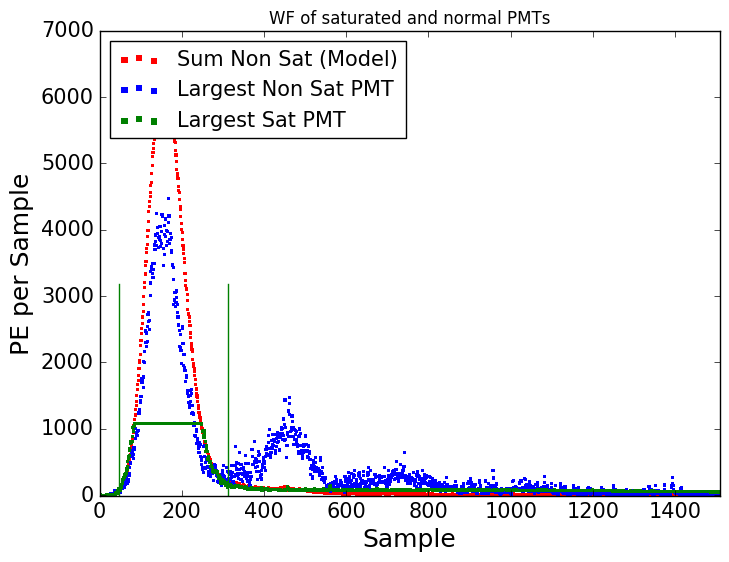

In [130]:
print(len(wf_sum_nan_saturate))

print(end_sample-start_sample)
samples=np.zeros(end_sample-start_sample)
for i in range(0,len(samples)):
#    samples[i]=start_sample+i
    samples[i]=i

plt.figure(figsize=(8, 6))

my_colors = 'rbkymc'

plt.scatter(samples, wf_sum_nan_saturate, c='r', edgecolors='None', marker='s', s=5, label='Sum Non Sat (Model)')
plt.scatter(samples, wf_pmt_non_sat_to_plot, c='b', edgecolors='None', marker='s', s=5, label='Largest Non Sat PMT')
plt.scatter(samples, wf_pmt_sat_to_plot, c='g', edgecolors='None', marker='s', s=5, label='Largest Sat PMT')

plt.plot((peak_left_edge-start_sample, peak_left_edge-start_sample), (0, 0.5*np.max(wf_sum_nan_saturate)), 'g')
plt.plot((peak_right_edge-start_sample, peak_right_edge-start_sample), (0, 0.5*np.max(wf_sum_nan_saturate)), 'g')

plt.xlim(0, (end_sample-start_sample)*0.14)
plt.ylim(-5, np.amax(wf_sum_nan_saturate)*1.1)
#plt.ylim(-5, 2000)

plt.legend(loc='upper left', fontsize=15, markerscale=2)
plt.title('WF of saturated and normal PMTs')
plt.xlabel('Sample', fontsize=18)
plt.ylabel('PE per Sample', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.show()
    
#print(samples)